In [ ]:
# nopep8
import jax
import jax.numpy as jnp

from functools import partial
from tqdm import tqdm

import matplotlib.pyplot as plt
import matplotlib.patches as plp
import matplotlib.animation as animation
plt.rcParams.update({"text.usetex":False})

import os

import koopcore

# nopep8

# Lattice-Boltzmann Simulation Routine

In [ ]:
def gen_sim_data(N_ITERATIONS, REYNOLDS_NUMBER, N_POINTS_X, N_POINTS_Y, MAX_HORIZONTAL_INFLOW_VELOCITY, SKIP_FIRST_N_ITERATIONS, SAVE_EVERY_N_STEPS, PROGRESSBAR, CYLINDER_CENTER_INDEX_X, CYLINDER_CENTER_INDEX_Y, CYLINDER_RADIUS_INDICES):
    r"""
    LBM Grid: D2Q9
        6   2   5
        \ | /
        3 - 0 - 1
        / | \
        7   4   8 
    """

    N_DISCRETE_VELOCITIES = 9

    LATTICE_VELOCITIES = jnp.array([
        [0, 1, 0, -1, 0, 1, -1, -1, 1,],
        [0, 0, 1, 0, -1, 1, 1, -1, -1,]
    ])

    LATTICE_INDICES = jnp.array([
        0, 1, 2, 3, 4, 5, 6, 7, 8,
    ])

    OPPOSITE_LATTICE_INDICES = jnp.array([
        0, 3, 4, 1, 2, 7, 8, 5, 6,
    ])

    LATTICE_WEIGHTS = jnp.array([
        4 / 9,                        # Center Velocity [0,]
        1 / 9, 1 / 9, 1 / 9, 1 / 9,      # Axis-Aligned Velocities [1, 2, 3, 4]
        1 / 36, 1 / 36, 1 / 36, 1 / 36,     # 45 ° Velocities [5, 6, 7, 8]
    ])

    RIGHT_VELOCITIES = jnp.array([1, 5, 8])
    UP_VELOCITIES = jnp.array([2, 5, 6])
    LEFT_VELOCITIES = jnp.array([3, 6, 7])
    DOWN_VELOCITIES = jnp.array([4, 7, 8])
    PURE_VERTICAL_VELOCITIES = jnp.array([0, 2, 4])
    PURE_HORIZONTAL_VELOCITIES = jnp.array([0, 1, 3])

    @jax.jit
    def get_density(discrete_velocities):
        density = jnp.sum(discrete_velocities, axis=-1)

        return density

    @jax.jit
    def get_macroscopic_velocities(discrete_velocities, density):
        macroscopic_velocities = jnp.einsum(
            "NMQ,dQ->NMd",
            discrete_velocities,
            LATTICE_VELOCITIES,
        ) / density[..., jnp.newaxis]

        return macroscopic_velocities

    def get_equilibrium_discrete_velocities(macroscopic_velocities, density):
        projected_discrete_velocities = jnp.einsum(
            "dQ,NMd->NMQ",
            LATTICE_VELOCITIES,
            macroscopic_velocities,
        )
        macroscopic_velocity_magnitude = jnp.linalg.norm(
            macroscopic_velocities,
            axis=-1,
            ord=2,
        )
        equilibrium_discrete_velocities = (
            density[..., jnp.newaxis]
            *
            LATTICE_WEIGHTS[jnp.newaxis, jnp.newaxis, :]
            *
            (
                1
                +
                3 * projected_discrete_velocities
                +
                9 / 2 * projected_discrete_velocities**2
                -
                3 / 2 * macroscopic_velocity_magnitude[..., jnp.newaxis]**2
            )
        )

        return equilibrium_discrete_velocities

    # jax.config.update("jax_enable_x64", True)

    kinematic_viscosity = (
        (
            MAX_HORIZONTAL_INFLOW_VELOCITY
            *
            CYLINDER_RADIUS_INDICES
        ) / (
            REYNOLDS_NUMBER
        )
    )
    relaxation_omega = (
        (
            1.0
        ) / (
            3.0
            *
            kinematic_viscosity
            +
            0.5
        )
    )

    # Define a mesh
    x = jnp.arange(N_POINTS_X)
    y = jnp.arange(N_POINTS_Y)
    X, Y = jnp.meshgrid(x, y, indexing="ij")

    # Obstacle Mask: An array of the shape like X or Y, but contains True if the
    # point belongs to the obstacle and False if not
    obstacle_mask = (
        jnp.sqrt(
            (
                X
                -
                CYLINDER_CENTER_INDEX_X
            )**2
            +
            (
                Y
                -
                CYLINDER_CENTER_INDEX_Y
            )**2
        )
        <
        CYLINDER_RADIUS_INDICES
    )

    velocity_profile = jnp.zeros((N_POINTS_X, N_POINTS_Y, 2))
    velocity_profile = velocity_profile.at[:, :, 0].set(MAX_HORIZONTAL_INFLOW_VELOCITY)

    @jax.jit
    def update(discrete_velocities_prev):
        # (1) Prescribe the outflow BC on the right boundary
        discrete_velocities_prev = discrete_velocities_prev.at[-1, :, LEFT_VELOCITIES].set(
            discrete_velocities_prev[-2, :, LEFT_VELOCITIES]
        )

        # (2) Macroscopic Velocities
        density_prev = get_density(discrete_velocities_prev)
        macroscopic_velocities_prev = get_macroscopic_velocities(
            discrete_velocities_prev,
            density_prev,
        )

        # (3) Prescribe Inflow Dirichlet BC using Zou/He scheme
        macroscopic_velocities_prev =\
            macroscopic_velocities_prev.at[0, 1:-1, :].set(
                velocity_profile[0, 1:-1, :]
            )
        density_prev = density_prev.at[0, :].set(
            (
                get_density(discrete_velocities_prev[0, :, PURE_VERTICAL_VELOCITIES].T)
                +
                2 *
                get_density(discrete_velocities_prev[0, :, LEFT_VELOCITIES].T)
            ) / (
                1 - macroscopic_velocities_prev[0, :, 0]
            )
        )

        # (4) Compute discrete Equilibria velocities
        equilibrium_discrete_velocities = get_equilibrium_discrete_velocities(
            macroscopic_velocities_prev,
            density_prev,
        )

        # (3) Belongs to the Zou/He scheme
        discrete_velocities_prev = \
            discrete_velocities_prev.at[0, :, RIGHT_VELOCITIES].set(
                equilibrium_discrete_velocities[0, :, RIGHT_VELOCITIES]
            )

        # (5) Collide according to BGK
        discrete_velocities_post_collision = (
            discrete_velocities_prev
            -
            relaxation_omega
            *
            (
                discrete_velocities_prev
                -
                equilibrium_discrete_velocities
            )
        )

        # (6) Bounce-Back Boundary Conditions to enfore the no-slip
        for i in range(N_DISCRETE_VELOCITIES):
            discrete_velocities_post_collision =\
                discrete_velocities_post_collision.at[obstacle_mask, LATTICE_INDICES[i]].set(
                    discrete_velocities_prev[obstacle_mask, OPPOSITE_LATTICE_INDICES[i]]
                )

        # (7) Stream alongside lattice velocities
        discrete_velocities_streamed = discrete_velocities_post_collision
        for i in range(N_DISCRETE_VELOCITIES):
            discrete_velocities_streamed = discrete_velocities_streamed.at[:, :, i].set(
                jnp.roll(
                    jnp.roll(
                        discrete_velocities_post_collision[:, :, i],
                        LATTICE_VELOCITIES[0, i],
                        axis=0,
                    ),
                    LATTICE_VELOCITIES[1, i],
                    axis=1,
                )
            )

        return discrete_velocities_streamed

    discrete_velocities_prev = get_equilibrium_discrete_velocities(
        velocity_profile,
        jnp.ones((N_POINTS_X, N_POINTS_Y)),
    )

    obs_vel_m = []
    obs_vort_m = []
    i_ter = []
    if PROGRESSBAR:
        it = tqdm(range(N_ITERATIONS))
    else:
        it = range(N_ITERATIONS)
    for iteration_index in it:
        discrete_velocities_next = update(discrete_velocities_prev)

        discrete_velocities_prev = discrete_velocities_next

        if iteration_index % SAVE_EVERY_N_STEPS == 0 and iteration_index > SKIP_FIRST_N_ITERATIONS:
            # ax[1].clear()
            density = get_density(discrete_velocities_next)
            macroscopic_velocities = get_macroscopic_velocities(
                discrete_velocities_next,
                density,
            )
            velocity_magnitude = jnp.linalg.norm(
                macroscopic_velocities,
                axis=-1,
                ord=2,
            )
            obs_vel_m.append(velocity_magnitude)
            d_u__d_x, d_u__d_y = jnp.gradient(macroscopic_velocities[..., 0])
            d_v__d_x, d_v__d_y = jnp.gradient(macroscopic_velocities[..., 1])
            curl = (d_u__d_y - d_v__d_x)
            obs_vort_m.append(curl)
            i_ter.append(iteration_index)

    i_ter = jnp.squeeze(jnp.stack(i_ter))
    obs_vel_m = jnp.stack(obs_vel_m)
    obs_vort_m = jnp.stack(obs_vort_m)
    return {"i": i_ter, "velocity_magnitude": obs_vel_m.transpose(0, 2, 1), "vorticity": obs_vort_m.transpose(0, 2, 1)}

# Configuration

In [ ]:
SAMPLE_MODE = "grid" # "random"
MAX_DEVIATION = 3
N_SAMPLES = 100 # only for random

N_ITERATIONS = 10_000
REYNOLDS_NUMBER = 40

N_POINTS_X = 100
N_POINTS_Y = 50

CYLINDER_CENTER_INDEX_X = N_POINTS_X // 5
CYLINDER_CENTER_INDEX_Y = N_POINTS_Y // 2
CYLINDER_RADIUS_INDICES = N_POINTS_Y // 9

MAX_HORIZONTAL_INFLOW_VELOCITY = 0.05

PROGRESSBAR = True
SAVE_EVERY_N_STEPS = 50
SKIP_FIRST_N_ITERATIONS = 5000
try:
    jax.devices("gpu")
    jax.config.update("jax_platform_name", "gpu")
except:
    jax.config.update("jax_platform_name", "cpu")
PATH_TO_RESULTS = "./results/LBM_cylinder_vortex_street"
os.makedirs(PATH_TO_RESULTS, exist_ok=True)


CUDA backend failed to initialize: Unable to load CUDA. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


# Simulation

In [ ]:
if SAMPLE_MODE == "grid":
    runs_args = jnp.stack(*[jnp.meshgrid(jnp.arange(-MAX_DEVIATION, MAX_DEVIATION+1), jnp.arange(-MAX_DEVIATION, MAX_DEVIATION+1))]).reshape(2, -1).T
elif SAMPLE_MODE == "random":
    runs_args = jnp.array(jnp.round(koopcore.auxilliary.sample_box(N_SAMPLES, jnp.array([[-3, 3], [-3, 3]]))[0]), dtype=int)

gen_sim_by_cylinder = partial(gen_sim_data, N_ITERATIONS, REYNOLDS_NUMBER, N_POINTS_X, N_POINTS_Y, MAX_HORIZONTAL_INFLOW_VELOCITY, SKIP_FIRST_N_ITERATIONS, SAVE_EVERY_N_STEPS, False)

In [ ]:
list_runs = []
for dx, dy in tqdm(runs_args):
    list_runs.append(
        gen_sim_by_cylinder(CYLINDER_CENTER_INDEX_X + dx, CYLINDER_CENTER_INDEX_Y+dy, CYLINDER_RADIUS_INDICES)
    )
    list_runs[-1].update({"Cylinder_Deviation":(dx, dy)})

100%|██████████| 49/49 [02:49<00:00,  3.46s/it]


In [ ]:
results_velm = jnp.concatenate(
    [
        results["velocity_magnitude"].reshape(1, results["velocity_magnitude"].shape[0], -1)
    for results in list_runs]
    )
results_vot = jnp.concatenate(
    [
        results["vorticity"].reshape(1, results["vorticity"].shape[0], -1)
    for results in list_runs]
    )
jnp.save(PATH_TO_RESULTS+"/velocity_magnitude.npy", results_velm)
jnp.save(PATH_TO_RESULTS+"/vorticity.npy", results_vot)
jnp.save(PATH_TO_RESULTS+"/cylinder_position.npy", runs_args)

In [ ]:
print("Minimum velocity magnitude: {:.2e}, \nMaximum velocity magnitude: {:.2e}".format(jnp.stack([ list_runs[i]["velocity_magnitude"] for i in range(len(runs_args))]).min(), jnp.stack([ list_runs[i]["velocity_magnitude"] for i in range(len(runs_args))]).max()))

Minimum velocity magnitude: 4.28e-06, 
Maximum velocity magnitude: 8.40e-02


# Plotting Results

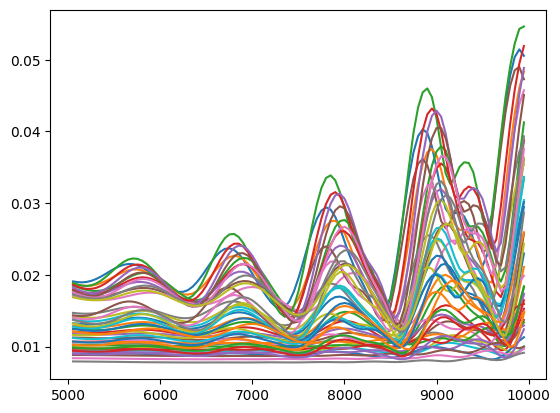

In [ ]:
ix, iy = (25, 80)
plt.figure()
for results in list_runs:
    plt.plot(results["i"], results["velocity_magnitude"][:, ix, iy])
# plt.figure()
# for results in list_runs:
#     plt.plot(results["i"], results["vorticity"][:, ix, iy])
# plt.show()
plt.show()


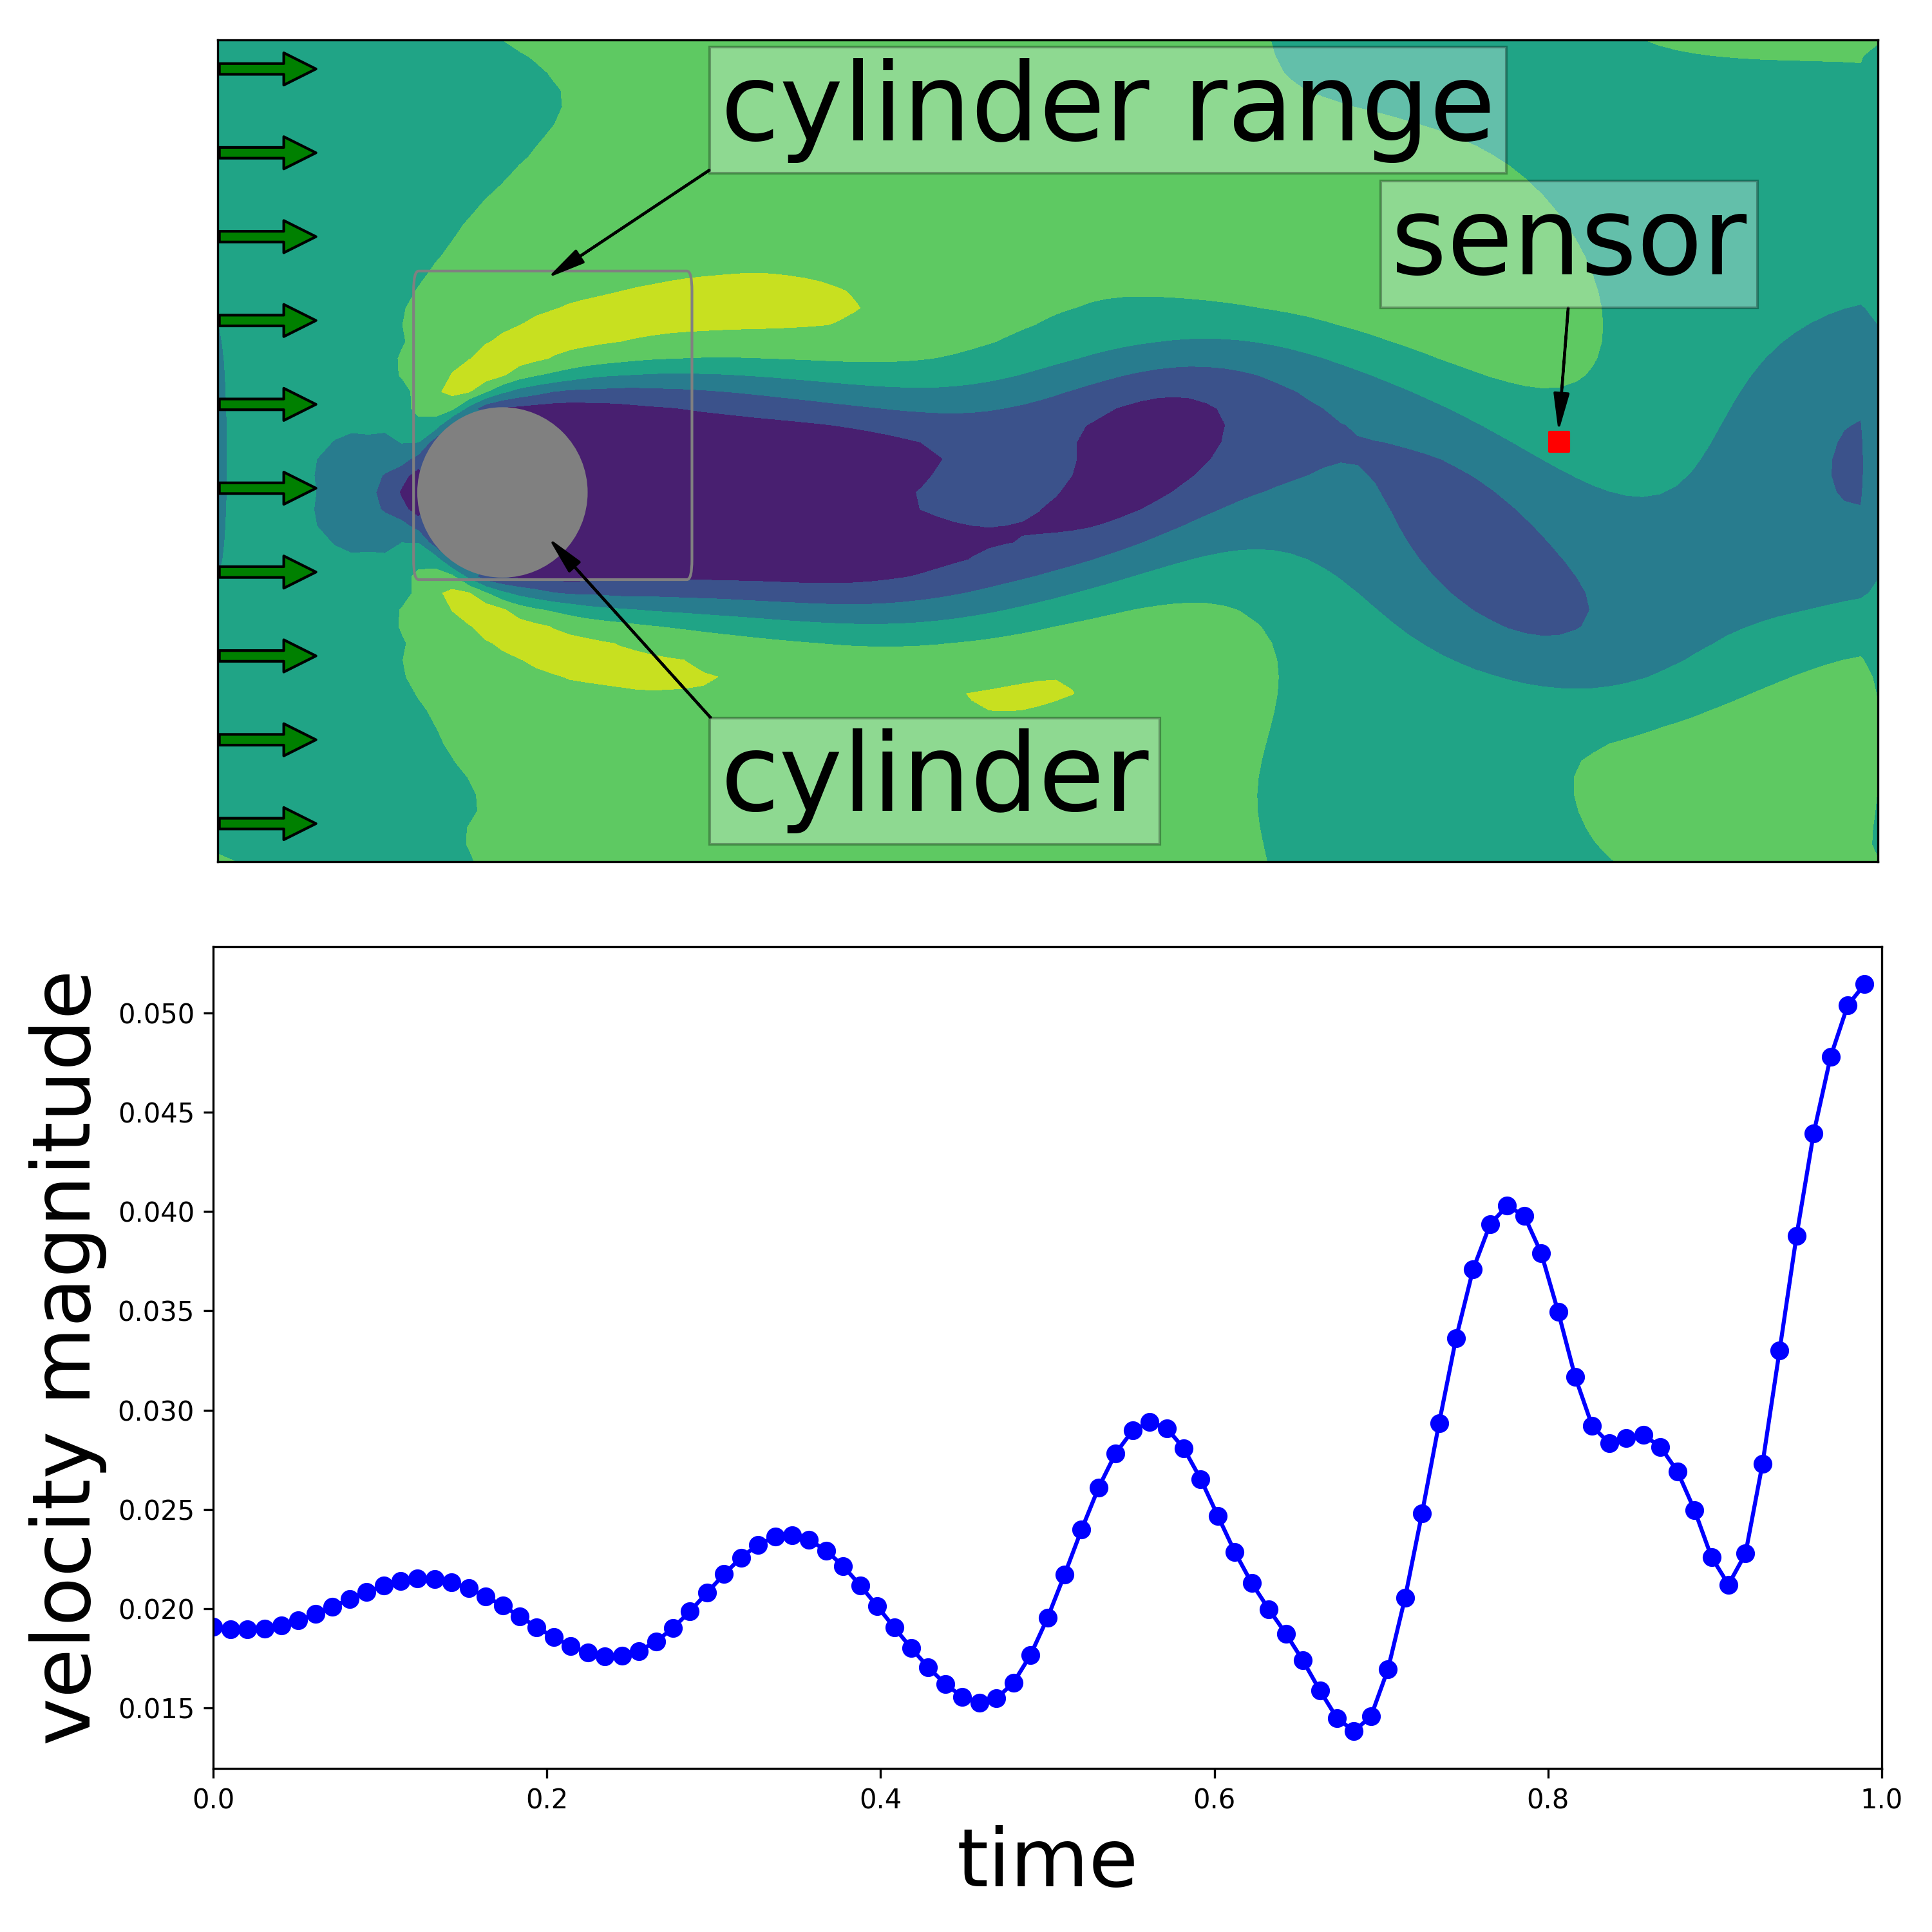

In [ ]:
%matplotlib widget
from matplotlib.ticker import FormatStrFormatter
run_idx = 0
cylinder_deviation =runs_args[run_idx]
results= list_runs[run_idx]
fig, axs = plt.subplots(2, 1, figsize=(10,10 ), dpi=300)
time = jnp.linspace(0, 1, 99)
ax = axs[0]
ax2 = axs[1]
ax.set_aspect("equal")
ax2.set_ylabel("velocity magnitude", fontdict={"fontsize":30})
ax2.set_xlabel("time", fontdict={"fontsize":30})
ax2.yaxis.set_major_formatter(FormatStrFormatter('%.3f'))
plt.tight_layout()
# plt.tight_layout()
def update_animation(iframe):
    
    ax.clear()
    ax.contourf(results["velocity_magnitude"][iframe])
    ax.scatter(iy, ix, color="red", s=50, marker="s")#, marker="square")
    ax.add_patch(plp.Circle( (CYLINDER_CENTER_INDEX_X+cylinder_deviation[0], CYLINDER_CENTER_INDEX_Y+cylinder_deviation[1]), CYLINDER_RADIUS_INDICES, fill=True, color="gray"), )
    # ax.add_patch(plp.Circle( (CYLINDER_CENTER_INDEX_X, CYLINDER_CENTER_INDEX_Y), CYLINDER_RADIUS_INDICES+int(jnp.ceil((18)**0.5)), fill=False, color="gray"), )
    
    ax.set_xticks([])
    ax.set_yticks([])
    for i in range(10):
        ax.annotate('', xy=(6, i*5+2.25), xytext=(0, i*5+2.25), arrowprops=dict(facecolor='green', shrink=0.02))
    if iframe < 10 or 1:
        ax.add_patch(plp.FancyBboxPatch( (CYLINDER_CENTER_INDEX_X-3-CYLINDER_RADIUS_INDICES, CYLINDER_CENTER_INDEX_Y-2-CYLINDER_RADIUS_INDICES), 6+2*CYLINDER_RADIUS_INDICES, 6+2*CYLINDER_RADIUS_INDICES, 
                                    fill=False, 
                                    ec="gray", fc="gray",
                                    mutation_aspect=4
                        ))
        ax.annotate('sensor', xy=(iy, ix+1), xytext=(iy-10, ix+10),  fontsize=40,
                arrowprops=dict(facecolor='black',  width=0.1, headwidth=5),bbox={"fill":True, "facecolor":"white", "edgecolor":None,  "alpha":0.3})
        ax.annotate('cylinder', xy=(CYLINDER_CENTER_INDEX_X, CYLINDER_CENTER_INDEX_Y-6), xytext=(CYLINDER_CENTER_INDEX_X+10, CYLINDER_CENTER_INDEX_Y-22), fontsize=40,
                arrowprops=dict(facecolor='black',  width=0.1, headwidth=5),bbox={"fill":True, "facecolor":"white", "edgecolor":None,  "alpha":0.3})
        ax.annotate('cylinder range', xy=(CYLINDER_CENTER_INDEX_X, CYLINDER_CENTER_INDEX_Y+5+CYLINDER_RADIUS_INDICES), xytext=(CYLINDER_CENTER_INDEX_X+10, CYLINDER_CENTER_INDEX_Y+18), fontsize=40,
                arrowprops=dict(facecolor='black',  width=0.1, headwidth=5),bbox={"fill":True, "facecolor":"white", "edgecolor":None,  "alpha":0.3})
    # ax.annotate('', xy=(6, 49), xytext=(0, 49),
    #                 arrowprops=dict(facecolor='green', shrink=0.02))
    ax2.clear()
    ax2.yaxis.set_major_formatter(FormatStrFormatter('%.3f'))
    ax2.scatter(time[:iframe], results["velocity_magnitude"][:iframe, ix, iy], color="blue")
    ax2.plot(time[:iframe], results["velocity_magnitude"][:iframe, ix, iy], color="blue")
    ax2.set_xlim([0, 1])
    ax2.set_ylabel("velocity magnitude", fontdict={"fontsize":30})
    ax2.set_xlabel("time", fontdict={"fontsize":30})
    # plt.tight_layout()


ani = animation.FuncAnimation(fig,update_animation,frames=results["i"].shape[0],interval=50,blit=False, repeat=False)

# To save the animation using Pillow as a gif
writer = animation.PillowWriter(fps=10,
                                metadata=dict(artist='Me'),
                                bitrate=1800)
ani.save(f'{PATH_TO_RESULTS}/wake.gif', writer=writer)
plt.show()

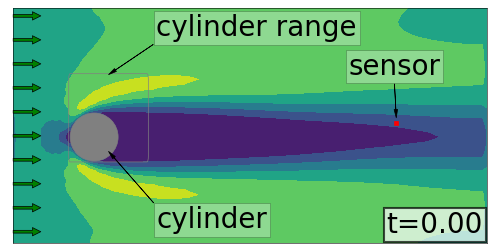

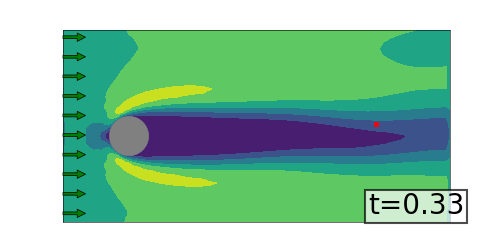

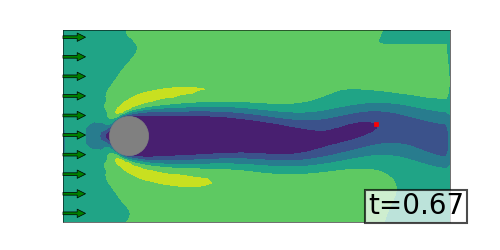

In [ ]:
%matplotlib widget
run_idx = 0
cylinder_deviation =runs_args[run_idx]
results= list_runs[run_idx]
# fig, axs = plt.subplots(1, 1, figsize=(8,8 ), dpi=50)
# time = jnp.linspace(0, 1, 99)
# ax = ax
# ax.set_aspect("equal")
def update_plot(iframe, ax):
    
    ax.clear()
    ax.contourf(results["velocity_magnitude"][iframe])
    ax.scatter(iy, ix, color="red", s=50, marker="s")#, marker="square")
    ax.add_patch(plp.Circle( (CYLINDER_CENTER_INDEX_X+cylinder_deviation[0], CYLINDER_CENTER_INDEX_Y+cylinder_deviation[1]), CYLINDER_RADIUS_INDICES, fill=True, color="gray"), )
    # ax.add_patch(plp.Circle( (CYLINDER_CENTER_INDEX_X, CYLINDER_CENTER_INDEX_Y), CYLINDER_RADIUS_INDICES+int(jnp.ceil((18)**0.5)), fill=False, color="gray"), )
    
    ax.set_xticks([])
    ax.set_yticks([])
    for i in range(10):
        ax.annotate('', xy=(6, i*5+2.25), xytext=(0, i*5+2.25), arrowprops=dict(facecolor='green', shrink=0.02))
    if iframe == 0:
        ax.add_patch(plp.FancyBboxPatch( (CYLINDER_CENTER_INDEX_X-3-CYLINDER_RADIUS_INDICES, CYLINDER_CENTER_INDEX_Y-2-CYLINDER_RADIUS_INDICES), 6+2*CYLINDER_RADIUS_INDICES, 6+2*CYLINDER_RADIUS_INDICES, 
                                    fill=False, 
                                    ec="gray", fc="gray",
                                    mutation_aspect=4
                        ))
        ax.annotate('sensor', xy=(iy, ix+1), xytext=(iy-10, ix+10),  fontsize=40,
                arrowprops=dict(facecolor='black',  width=0.1, headwidth=5),bbox={"fill":True, "facecolor":"white", "edgecolor":None,  "alpha":0.3})
        ax.annotate('cylinder', xy=(CYLINDER_CENTER_INDEX_X, CYLINDER_CENTER_INDEX_Y-6), xytext=(CYLINDER_CENTER_INDEX_X+10, CYLINDER_CENTER_INDEX_Y-22), fontsize=40,
                arrowprops=dict(facecolor='black',  width=0.1, headwidth=5),bbox={"fill":True, "facecolor":"white", "edgecolor":None,  "alpha":0.3})
        ax.annotate('cylinder range', xy=(CYLINDER_CENTER_INDEX_X, CYLINDER_CENTER_INDEX_Y+5+CYLINDER_RADIUS_INDICES), xytext=(CYLINDER_CENTER_INDEX_X+10, CYLINDER_CENTER_INDEX_Y+18), fontsize=40,
                arrowprops=dict(facecolor='black',  width=0.1, headwidth=5),bbox={"fill":True, "facecolor":"white", "edgecolor":None,  "alpha":0.3})
        plt.tight_layout()
    return ax

lf = []
for i in [0, 32, 66, 98]:
        fig, axs = plt.subplots(1, 1, figsize=(10,5 ), dpi=50)
        ax = axs
        ax.set_aspect("equal")
        ax = update_plot(i, ax)

        plt.text(78, 2, f"t={i/98:.2f}", fontdict=None, fontsize=40,bbox={"fill":True, "facecolor":"white", "edgecolor":"black", "linewidth":3, "alpha":0.7})
        plt.savefig(f'{PATH_TO_RESULTS}/wake_{i}.pdf',  dpi=fig.dpi)

plt.close()